In [14]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# Ensure path for src imports
from imblearn.over_sampling import SMOTE
from src.preprocessing import calculate_velocity_features
sys.path.append(os.path.abspath(".."))
from src.preprocessing import preprocess_data
import importlib
import src.preprocessing
import src.feature_engineering
importlib.reload(src.preprocessing)
importlib.reload(src.feature_engineering)

<module 'src.feature_engineering' from 'c:\\Users\\hp\\Downloads\\KAIM\\KAIM-WEEK5\\Ecommerce-Banking-Fraud-Detection-ML\\src\\feature_engineering.py'>

# Feature Engineering and Transformation

This notebook handles advanced feature creation, encoding, scaling, and imbalance correction for the fraud detection model.

## 1. Setup and Data Loading

Load and preprocess the fraud data using existing cleaning functions.

In [15]:
# Load cleaned fraud data
merged_df = preprocess_data("../data/raw/Fraud_Data.csv", "../data/raw/IpAddress_to_Country.csv")
print(f"Loaded data shape: {merged_df.shape}")
print(merged_df.head())

Loaded data shape: (129146, 17)
     user_id         signup_time       purchase_time  purchase_value  \
634   247547 2015-06-28 03:00:34 2015-08-09 03:57:29              47   
635   220737 2015-01-28 14:21:11 2015-02-11 20:28:28              15   
636   390400 2015-03-19 20:49:09 2015-04-11 23:41:23              44   
637    69592 2015-02-24 06:11:57 2015-05-23 16:40:14              55   
638   174987 2015-07-07 12:58:11 2015-11-03 04:04:30              51   

         device_id  source browser sex  age  ip_address  class  \
634  KIXYSVCHIPQBR     SEO  Safari   F   30    16778864      0   
635  PKYOWQKWGJNJI     SEO  Chrome   F   34    16842045      0   
636  LVCSXLISZHVUO     Ads      IE   M   29    16843656      0   
637  UHAUHNXXUADJE  Direct  Chrome   F   30    16938732      0   
638  XPGPMOHIDRMGE     SEO  Chrome   F   37    16971984      0   

     lower_bound_ip_address  upper_bound_ip_address    country  \
634              16778240.0              16779263.0  Australia   
635   

## 2. Feature Engineering (Creation)

Create time-based, velocity, and frequency features.

In [16]:
# Velocity and Time features
merged_df['hour_of_day'] = merged_df['purchase_time'].dt.hour
merged_df['day_of_week'] = merged_df['purchase_time'].dt.dayofweek
merged_df['time_since_signup'] = (merged_df['purchase_time'] - merged_df['signup_time']).dt.total_seconds()

# Calculate Velocity Features (Using helper function)
merged_df = calculate_velocity_features(merged_df)

print("Features added/verified:")
print(merged_df[['hour_of_day', 'day_of_week', 'time_since_signup', 'user_tx_count']].head())


Features added:
     hour_of_day  day_of_week  time_since_signup  transaction_frequency
634            3            6          3632215.0                      1
635           20            2          1231637.0                      1
636           23            5          1997534.0                      1
637           16            5          7640897.0                      1
638            4            1         10249579.0                      1


## 3. Transformation (Encoding and Scaling)

Apply one-hot encoding to categorical features and scaling to numerical ones.

In [17]:
# One-hot encoding
categorical_cols = ['source', 'browser', 'sex']
encoded_df = pd.get_dummies(merged_df[categorical_cols], drop_first=True)
merged_df = pd.concat([merged_df.drop(categorical_cols, axis=1), encoded_df], axis=1)

# Scaling (only numerical features, exclude one-hot and target)
scaler = StandardScaler()
numerical_cols = ['purchase_value', 'age', 'user_tx_count', 'time_since_signup']
merged_df[numerical_cols] = scaler.fit_transform(merged_df[numerical_cols])

print(f"Data shape after transformation: {merged_df.shape}")
print(merged_df.head())

Data shape after transformation: (129146, 22)
     user_id         signup_time       purchase_time  purchase_value  \
634   247547 2015-06-28 03:00:34 2015-08-09 03:57:29        0.549607   
635   220737 2015-01-28 14:21:11 2015-02-11 20:28:28       -1.197335   
636   390400 2015-03-19 20:49:09 2015-04-11 23:41:23        0.385831   
637    69592 2015-02-24 06:11:57 2015-05-23 16:40:14        0.986342   
638   174987 2015-07-07 12:58:11 2015-11-03 04:04:30        0.767974   

         device_id       age  ip_address  class  lower_bound_ip_address  \
634  KIXYSVCHIPQBR -0.363124    16778864      0              16778240.0   
635  PKYOWQKWGJNJI  0.101168    16842045      0              16809984.0   
636  LVCSXLISZHVUO -0.479197    16843656      0              16843264.0   
637  UHAUHNXXUADJE -0.363124    16938732      0              16924672.0   
638  XPGPMOHIDRMGE  0.449387    16971984      0              16941056.0   

     upper_bound_ip_address  ... hour_of_day  day_of_week  \
634      

## 4. Imbalance Handling (SMOTE)

Split data and apply SMOTE to the training set only.

In [18]:
# Define X and y
X = merged_df.drop(['class', 'user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address', 'lower_bound_ip_address', 'upper_bound_ip_address'], axis=1).select_dtypes(include=[float, int, bool])
y = merged_df['class']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"y_train shape before SMOTE: {y_train.shape}")
print(y_train.value_counts())

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print(f"Train shape before: {X_train.shape}")
print(f"Train shape after SMOTE: {X_train_sm.shape}")
print(f"y_train shape after SMOTE: {y_train_sm.shape}")
print(y_train_sm.value_counts())


y_train shape before SMOTE: (103316,)
class
0    93502
1     9814
Name: count, dtype: int64
y_train shape after SMOTE: (187004,)
class
0    93502
1    93502
Name: count, dtype: int64


## 5. Save Processed Data

Save the training and test sets to processed folder.

In [19]:
# Save training data (SMOTE applied)
train_df = pd.concat([X_train_sm, y_train_sm], axis=1)
train_df.to_csv('../data/processed/train_enc_smote.csv', index=False)

# Save test data (untouched)
test_df = pd.concat([X_test, y_test], axis=1)
test_df.to_csv('../data/processed/test_enc.csv', index=False)

print("Data saved successfully.")

Data saved successfully.


## 6. Post-Transformation Visualizations

Visualize the transformed data and class balance after SMOTE.

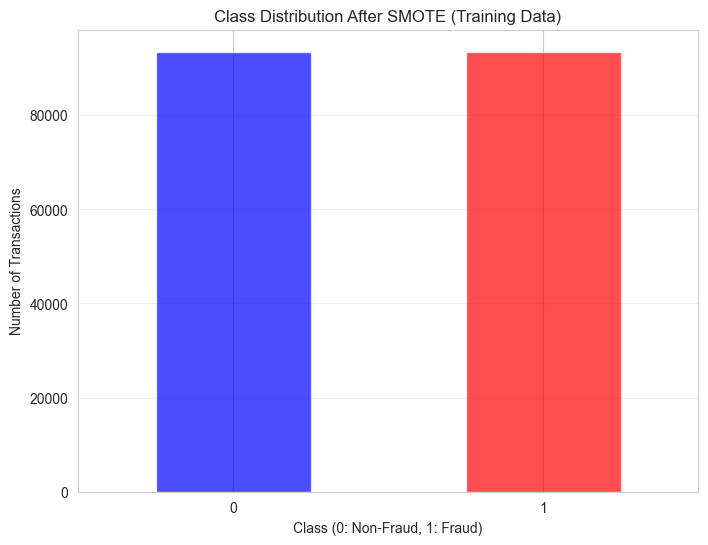

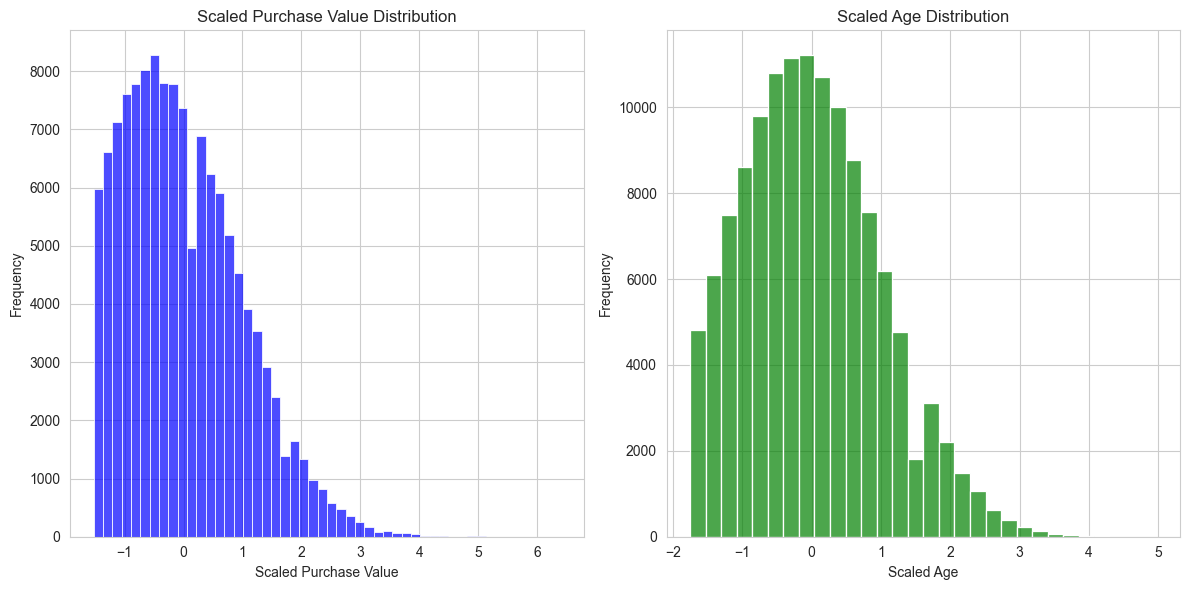

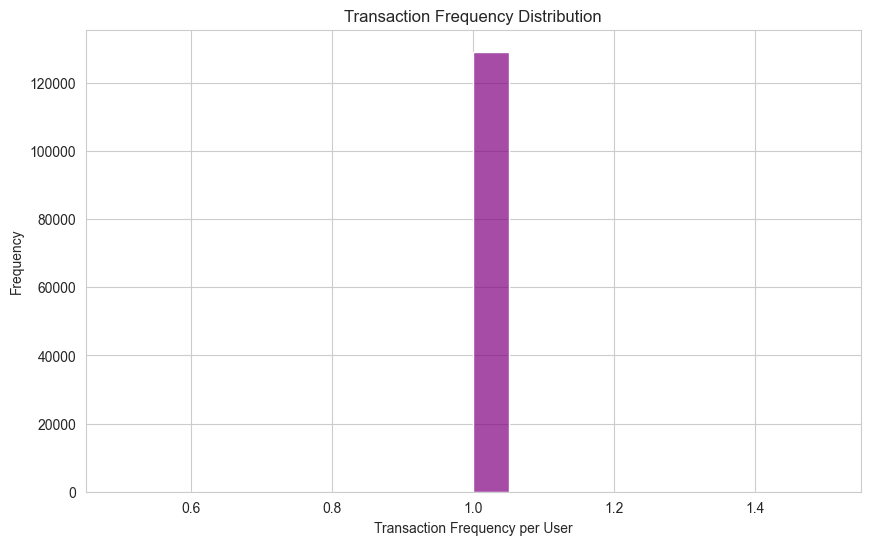

Post-transformation visualizations generated and saved to images/ folder.


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# 1. Class Distribution After SMOTE
plt.figure(figsize=(8, 6))
y_train_sm.value_counts().plot(kind='bar', color=['blue', 'red'], alpha=0.7)
plt.title('Class Distribution After SMOTE (Training Data)')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.savefig('../images/class_distribution_smote.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Scaled Features Distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(merged_df['purchase_value'], bins=50, alpha=0.7, color='blue')
plt.title('Scaled Purchase Value Distribution')
plt.xlabel('Scaled Purchase Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(merged_df['age'], bins=30, alpha=0.7, color='green')
plt.title('Scaled Age Distribution')
plt.xlabel('Scaled Age')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('../images/scaled_features_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Transaction Frequency Distribution
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['transaction_frequency'], bins=20, alpha=0.7, color='purple')
plt.title('Transaction Frequency Distribution')
plt.xlabel('Transaction Frequency per User')
plt.ylabel('Frequency')
plt.savefig('../images/transaction_frequency_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Post-transformation visualizations generated and saved to images/ folder.")